Позаботимся о надежной загрузке и выгрузке модели, чтобы не потерять прогресс. Использовал FTP как универсальный способ для всех платформ.

In [1]:
import ftplib

def uploadToFTP(name):
    session = ftplib.FTP('HOST','user','password')
    file = open(name,'rb')                  # file to send
    session.storbinary(f'STOR {name}', file)     # send the file
    file.close()                                    # close file and FTP
    session.quit()
    
    
def downloadFromFTP(name):
    session = ftplib.FTP('HOST','user','password')
    session.retrbinary(f'RETR {name}', open(name, 'wb').write)

    session.quit()

In [2]:
import os 

dfile = "netD_4x_checkpoint.pth"
gfile = "netG_4x_checkpoint.pth"

if not os.path.isfile(gfile) or not os.path.isfile(dfile):
    downloadFromFTP(dfile)
    downloadFromFTP(gfile)
    print("File downloaded")

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

# Предобработка датасета

В процессе тренировки были испробованы различные методы работы с датасетом. Изначально датасет составляли 2к картинки из Flickr2K, OutdoorSceneTraining и Div2K датасетов без предварительной подготовки. Все эти датасеты были совмещены в один. Из них вырезались рандомные регионы по 128*128 пикселей. С помощью бикубического фильтра из данных картинок формировались low resolution картинки. Это все происходило на каждом запросе батча. Данный метод оказался очень неэффективным, потому что загрузка 2К картинок занимала много процессорного времени. Это было видно по тому, что видеокарта практически не загружена, зато активно использовался процессор, участвующий в подготовке батча.

В итоге было принято решение предобработать данный датасет скриптом cropper.py, который доступен в репозитории. Этот скрипт нарезает картинки на патчи по 128 пикселей. Получился датасет размером 630к картинок. Это привело к значительному ускорению процесса обучения. Если перед этим на итерацию по PSNR-ориентированному методу уходило около 5с, то теперь цикл PSNR делает две итерации в секунду.

Так же было обнаружено, что хотя датасет получился очень большой, не все 128-пиксельные патчи из него одинаково полезны. Много размытых и расфокусированных патчей. Чтобы исправить эту проблему, была предпринята попытка фильтрвать датасет. Написал скрипт sharpness.py, который так же доступен в репозитории. Он фильтрует исходный датасет по резкости изображения. Сначала он преобразует картинку в матрицу и вычисляет градиенты для данной матрицы. Затем по матрице градиентов вычисляется средний градиент и максимальный градиент. Картинки фильтруют по условиям, учитывая средний градиент (общая резкость изображения, удельный вес четких деталей на картинке) и максимальный градиент (наличие объектов на картинке, обладающих высокой детализацией). Размер датасета был уменьшен до 80к патчей.

Условие, по которому фильтровался датасет может быть выражено как:

$$\left[ 
  \begin{gathered} 
    \left\{ 
      \begin{gathered} 
        mean(\nabla G) > \alpha
        \\
        max(\nabla G) > \beta
        \\ 
      \end{gathered} 
    \right. \hfill 
    \\
        max(\nabla G) > \gamma
    \\ 
  \end{gathered} 
\right.$$
      
Где G - это исходное изображение. $\alpha = 30,\ \beta = 120,\ \gamma = 140$ - пороговые значения фильтрации.

Таким образом, в результирующий датасет попадают или картинки, где на большей части находится какое-то сложное избражение с хорошим фокусом, содержащее много деталей, либо изображения, где находится хотя бы один объект в очень хорошем фокусе и хорошо детализированный (фон при этом может быть размыт).

In [3]:
import torch.utils.data.dataset
import torchvision.transforms as transforms
from PIL import Image

class DatasetFromFolder(torch.utils.data.dataset.Dataset):

    def __init__(self, target_dir, hr_resize=128, lr_resize=32, interpolation=Image.BICUBIC):
        super(DatasetFromFolder, self).__init__()
        targetDir = os.listdir(target_dir)
        targetDir.sort()
        self.target_filenames = [os.path.join(target_dir, x) for x in targetDir]
        self.commonTransforms = transforms.Compose([
                                transforms.Resize((hr_resize, hr_resize), interpolation=interpolation),
#                                 transforms.RandomCrop(128, padding=None, pad_if_needed=True, fill=0, padding_mode='constant'),
                                transforms.RandomApply([transforms.RandomRotation((90,90))], p=0.5),
                                transforms.RandomHorizontalFlip(p=0.5)])
        
        self.targetTransforms = transforms.ToTensor()
        self.inputTransforms = transforms.Compose([transforms.Resize((lr_resize, lr_resize), interpolation=interpolation),
                                       transforms.ToTensor()])

    def __getitem__(self, index):
        image = Image.open(self.target_filenames[index])
        
        image = self.commonTransforms(image)
        target = self.targetTransforms(image)
        input = self.inputTransforms(image)

        return input, target

    def __len__(self):
        return len(self.target_filenames)

# Функции потерь

В обучении в том числе используется PerseptionLoss. Это умная функция потерь, вычисляющая разницу между фичемапами нейросети, на вход которой подается изображение сгенерированное нейросетью или ground truth. Это позволяет обучить модель воспроизводить фичи, паттерны, которые есть в таргете, без точного совмещения (например, они могут быть сдвинуты на несколько пикселей). Можно использовать фичемапы на различных слоях и складывать их с разными весами, но для упрощения кода поступлю так, как поступают наиболее часто -- буду использовать только фичемап 35 слоя (conv5_4 из оригинальной статьи SRGAN[1], обозначим как VGG54), а остальные слои после 35 просто отборшу. В статье [1] данный метод показал наиболее хорошие результаты.
Среди закомментированного кода оставлю вариант с подсчетом среднего лосса по всем слоям.
$$L_{VGG54} = 1/n\sum\limits_{i=1}^n{(\Phi_{5\_4}(I_i) - \Phi_{5\_4}(T_i))}$$
где $\Phi_{5\_4}$ - это выход conv5_4 слоя VGG

Обращаю внимание, что в отличие от SRGAN[1], в ESRGAN[2] выход слоя берется до функции активации.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torchvision.models import vgg19
import torchvision.transforms as transforms

from tqdm import tqdm
from IPython.display import clear_output

class Normalization(nn.Module):
      
    def __init__(self):
        super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
        self.transform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def forward(self, img):
            # normalize img
        return self.transform(img)


class PerceptionLoss(nn.Module):

    def __init__(self, feature_layer: int = 35) -> None:
        
        super(PerceptionLoss, self).__init__()
        model = vgg19(pretrained=True)
        ftlist = [Normalization()]
        ftlist.extend(list(model.features.children())[:feature_layer])
        self.features = nn.Sequential(*ftlist).eval()
        # Freeze parameters. Don't train.
        for name, param in self.features.named_parameters():
            param.requires_grad = False

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        
#         inp = input
#         tg = target
#         loss = 0
#         layer_count = 0
        
#         for layer in self.features.children():
#             inp = layer(inp)
#             tg = layer(tg)
#             if isinstance(layer, torch.nn.Conv2d):
#                 loss += F.mse_loss(inp.clone(), tg.clone())
#                 layer_count += 1
                
#         return loss / layer_count
                
        return F.l1_loss(self.features(input), self.features(target))


Будет использоваться так же межпиксельный лосс по метрике L1, который призван сохранять оригинальные оттенки и контраст исходного изображения, а так же не дает нейросети терять идентичность с оригиналом в процессе обучения на уровне мелких деталей.

$$ L_{1pix} = 1/n\sum_{n}(I_i - T_i)$$

А так же, собственно GAN loss, это BCEWithLogitsLoss, типично применяется при бинарной классификации, для предиктов выдаваемых дискриминатором, который определяет, является ли изображение фейком.

$$BCEWithLogits = 1/n\sum_{n}-(T_i * \log(\sigma(I_i)) + (1 - T_i) * \log(1 - \sigma(I_i)))$$

 На самом деле, в данном GAN все несколько сложнее, но я остановлюсь подробнее на этом позже, непосредственно при рассматрении алгоритма тренировки.

In [5]:
device = "cpu"

perception_criterion = PerceptionLoss().to(device) 
content_criterion = nn.L1Loss().to(device)
adversarial_criterion = nn.BCEWithLogitsLoss().to(device)

# Дискриминатор

Дискриминатор - классическая архитектура для классификации изображений подобная VGG. Последний слой оставляем открытым, так как активация используется в функции ошибки.

In [6]:
class Discriminator(nn.Module):
    r"""The main architecture of the discriminator. Similar to VGG structure."""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),  # input is 3 x 216 x 216
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),  # state size. (64) x 108 x 108
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False),  # state size. 128 x 54 x 54
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),  # state size. 256 x 27 x 27
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, bias=False),  # state size. 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((14, 14))

        self.fc = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(1024, 1),
            #nn.Sigmoid()
        )

    def forward(self, input: Tensor) -> Tensor:
        out = self.features(input)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


# Генератор

Основным элементом генератора являются ResidualDense блоки. Каждый Residual Dense блок представляет собой 5 сверточных слоев, имеющих между собой скип-коннекшены. С каждого слоя скип-коннекшен переносит фичепамы на все следующие слои, где они объединяются и подаются на вход слоя. Residual блок это широко распространенная архитектура в свероточных нейросетях. Они называются остаточными (Residual), потому что выход каждого слоя представляет собой разность между его входом и результирующим фичемапом, получающимся после объединения на выходе.

$$H(x) = x + F(x)$$

Где H(x) это выходные данные residual блока, x - входные данные, а F(x) - отображение, которое осуществляет непосредственно набор слоев, составляющих блок.

Dense (полносвязным) он называется потому, что все слои блока соединены со всеми последующими слоями.

Кроме того, в архитектуре RRDB данной нейросети, все Residual Dense блоки дополнены внешними скип-коннекшенами сквозь RDB блок, таким образом, вместе они составляют Residual in Residual Dense блок.
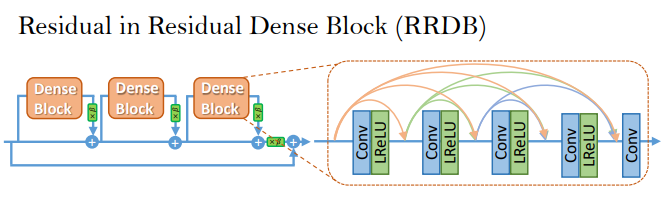

Такая архитеутура позволяет решить множество проблем, связанный с глубокими нейросетями. В особенности, затухание градиента. При обратном распространении ошибки, ошибки всех слоев Residual блока вычисляются через скип-коннекшены, что предотвращает gradient vanishing.

In [7]:
class ResidualDenseBlock(nn.Module):

    def __init__(self, in_channels, growth_channels, scale_ratio):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + 0 * growth_channels, growth_channels, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels + 1 * growth_channels, growth_channels, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels + 2 * growth_channels, growth_channels, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels + 3 * growth_channels, growth_channels, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.conv5 = nn.Conv2d(in_channels + 4 * growth_channels, in_channels, 3, 1, 1)

        self.scale_ratio = scale_ratio

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias.data, 0.0)

    def forward(self, input: Tensor) -> Tensor:
        conv1 = self.conv1(input)
        conv2 = self.conv2(torch.cat((input, conv1), 1))
        conv3 = self.conv3(torch.cat((input, conv1, conv2), 1))
        conv4 = self.conv4(torch.cat((input, conv1, conv2, conv3), 1))
        conv5 = self.conv5(torch.cat((input, conv1, conv2, conv3, conv4), 1))

        return conv5.mul(self.scale_ratio) + input


class ResidualInResidualDenseBlock(nn.Module):

    def __init__(self, in_channels, growth_channels, scale_ratio):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.RDB1 = ResidualDenseBlock(in_channels, growth_channels, scale_ratio)
        self.RDB2 = ResidualDenseBlock(in_channels, growth_channels, scale_ratio)
        self.RDB3 = ResidualDenseBlock(in_channels, growth_channels, scale_ratio)

        self.scale_ratio = scale_ratio

    def forward(self, input: Tensor) -> Tensor:
        out = self.RDB1(input)
        out = self.RDB2(out)
        out = self.RDB3(out)

        return out.mul(self.scale_ratio) + input


In [8]:
import math

class Generator(nn.Module):
    
    def __init__(self, upscale_factor, num_rrdb_blocks=23):

        super(Generator, self).__init__()
        num_upsample_block = int(math.log(upscale_factor, 2))

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

        rrdb_blocks = []
        for _ in range(num_rrdb_blocks):
            rrdb_blocks += [ResidualInResidualDenseBlock(in_channels=64, growth_channels=32, scale_ratio=0.2)]
        self.Trunk_RRDB = nn.Sequential(*rrdb_blocks)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        upsampling = []
        for _ in range(num_upsample_block):
            upsampling += [
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        self.conv4 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.convOut = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, input: Tensor) -> Tensor:
        out1 = self.conv1(input)
        out = self.Trunk_RRDB(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv4(out)
        out = self.convOut(out)

        return out

Будем использовать размер батча 16, как рекомендовано в статье[2].

In [9]:
batchSize = 16

upscaleFactor = 4


def setSeed(seed = 42):
    torch.manual_seed(seed)

# setSeed()

In [10]:
dataset = DatasetFromFolder(target_dir="/kaggle/input/cropflt/train")

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batchSize,
                                            pin_memory=True,
                                            shuffle=True)
                                         

In [11]:
netG = Generator(upscale_factor=upscaleFactor).to(device)
netD = Discriminator().to(device)
print(len(dataset))

79918


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def drawSamples(inp, fake, gd, figsize=(15, 10)):        
  # Visualize tools
    plt.figure(figsize=figsize)
    clear_output(wait=True)
    for k in range(5):
        plt.subplot(3, 5, k+1)
        plt.imshow(np.rollaxis(inp[k].numpy(), 0, 3))
        plt.title('Input')
        plt.axis('off')

        plt.subplot(3, 5, k+6)
        plt.imshow(np.rollaxis(fake[k].numpy(), 0, 3))
        plt.title('Fake')
        plt.axis('off')

        plt.subplot(3, 5, k+11)
        plt.imshow(np.rollaxis(gd[k].numpy(), 0, 3))
        plt.title('Ground Truth')
        plt.axis('off')
    plt.show()

In [13]:
RRDB_PSNR_pretrained_path = "PSNRV1_2PreTrained.pth"

# Обучение

Согласно [2], инициализиация генератора PSNR-ориентированной моделью позволяет значительно ускорить процесс обучения и добиться большей реалистичности.
PSNR-ориентированная модель (с англ. соотношение сигнал/шум) обучается по метрике L1 межпиксельного расстояния с таргетом. Модель таким образом учится минимизировать шумы и пикселизацию, получая изображение с гладкими и четкими границами. Недостатками данной модели являются крайняя бедность деталями и нереалистичность.

Цикл обучения достаточно тривиален. Укажу лишь, что ввиду постоянных экспериментов с датасетом и изменением его размера, я отказался от типичного понятия эпохи при обучении, и вместо этого ориентировался на число итераций по батчам. С 1 эпохой условно соотнес 1000 итераций.

Так же примечательным является то, что был применен косинусоидальный шедулер с рестартом. Это так называемый warm up, помогающий избежать остановки на локальном минимуме при оптимизации модели. Рестарт производится 4 раза, через каждые 250 000 итераций.

Цикл составлен с расчетом на то, что процесс обучения будет прерываться и возобновляться с чекпоинта.

In [14]:
def PreTrainRRDB():

    PSNREpochs = 1000
    optimizer = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                    T_0=PSNREpochs // 4,
                                                                    T_mult=1,
                                                                    eta_min=1e-7)
    iteration = 0
    if os.path.exists(RRDB_PSNR_pretrained_path):
        netG.load_state_dict(torch.load(RRDB_PSNR_pretrained_path, map_location=device)['state_dict'])
        optimizer.load_state_dict(torch.load(RRDB_PSNR_pretrained_path, map_location=device)['optimizer'])
        iteration = torch.load(RRDB_PSNR_pretrained_path, map_location=device)['iteration']

    netG.train()
    netD.train()
    
    for g in optimizer.param_groups:
        g['lr'] = 0.0002
    scheduler.step(iteration // 1000)
    

    while(iteration // 1000 < PSNREpochs):
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (input, target) in progress_bar:
            clear_output(wait=True)
            
            netG.zero_grad()
            
            lr = input.to(device)
            hr = target.to(device)
            
            sr = netG(lr)
            
            l1_loss = content_criterion(sr, hr)
            
            l1_loss.backward()
            
            optimizer.step()

            progress_bar.set_description(f"[{iteration // 1000}/{PSNREpochs}][{iteration + 1}/{len(dataloader)}] "
                                         f"L1 loss: {l1_loss.item():.6f} LR: {optimizer.param_groups[0]['lr']} ")
            
            drawSamples(lr.detach().cpu(), sr.detach().cpu(), hr.detach().cpu())
            iteration += 1
            
            if iteration % 1000 == 0:

                torch.save({"iteration": iteration,
                            "optimizer": optimizer.state_dict(),
                            "state_dict": netG.state_dict()
                            }, RRDB_PSNR_pretrained_path)
                
                uploadToFTP('PSNRV1_2PreTrained.pth')
                
                scheduler.step(iteration // 1000)

# PreTrainRRDB()

In [15]:
# netG.load_state_dict(torch.load(RRDB_PSNR_pretrained_path, map_location=device)['state_dict'])
# torch.autograd.set_detect_anomaly(True)

In [16]:
dfile = "netD_4x_checkpoint.pth"
gfile = "netG_4x_checkpoint.pth"

Цикл обучения GAN состоит из обучения дискриминатора и генератора. Сначала происходит итерация обучения дискриминатора, во время которой дискриминатор учится видеть разницу между фейковым изображением и ground truth. Данный GAN называется relativistic (связано с понятием "относительность"). В отличие обычного, релятивистский дискриминатор пытается определить вероятность того, что одно изображение более реалистично, чем другое, тогда как дискриминатор обычного GAN безотносительно определяет, является изображение реалистичным или нет.

Обозначим

$$D_{x_f, x_r} = \sigma(\mathscr{D}(F)) - E(\mathscr{D}(T)) \rightarrow 0\ (1)$$

$$D_{x_r, x_f} = \sigma(\mathscr{D}(T)) - E(\mathscr{D}(F)) \rightarrow 1\ (2)$$

где F - предикт генератора, T - Ground Truth, E - среднее, а $\mathscr{D}$ - выход дискриминатора с открытым последним слоем.

Выполнение условий оптимизации (1) и (2) означает, что дискриминатор отличает фейк от реального изображения.

GAN-лосс дискриминатора максимизирует:

   $$-E_{x_r}[\log(D_{x_r,x_f})] - E_{x_f}[1 - \log(D_{x_f,x_r})]$$
   
GAN-лосс генератора максимизирует:

   $$-E_{x_r}[1 - \log(D_{x_r,x_f})] - E_{x_f}[\log(D_{x_f,x_r})]$$
   
 
В обучении генератор используется суперпозиция трех лоссов:
   $$L_G = L_{VGG54} + \alpha * L_{adv} + \beta * L_{1pix}$$
   
Выбраны $\alpha = 0.005, \beta = 0.01$ следуя [2]

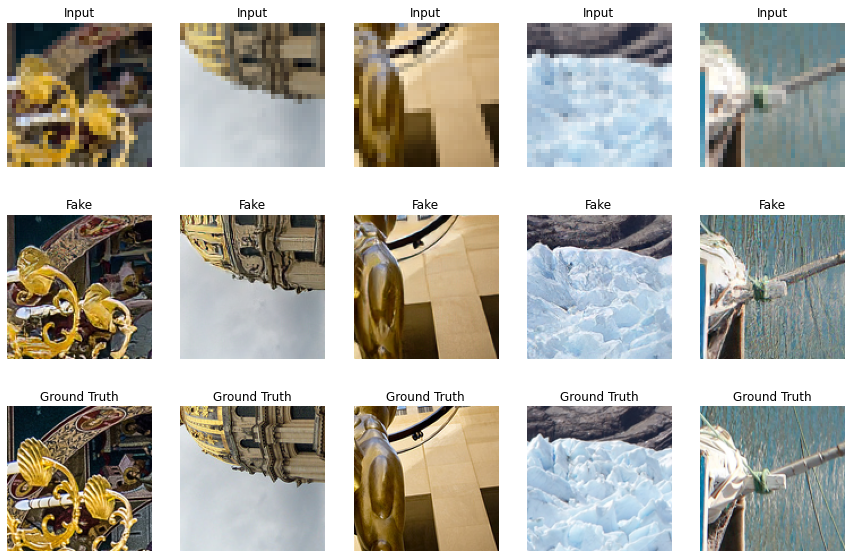

[547/600][1/4995] Loss_Dsr: 0.000004 Loss_Dhr: 0.000004 Loss_D: 0.000004 Loss_G: 1.591545 D(HR): -75.123543 D(G(LR)): -87.657814 LR: 8e-06 :   0%|          | 1/4995 [00:44<61:14:59, 44.15s/it]


KeyboardInterrupt: 

In [17]:
import time

def TrainGAN():
    
    sigmoid = torch.nn.Sigmoid()
    epochs = 600
    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(0.9, 0.999))
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.9, 0.999))

    iteration = 0
    if os.path.exists(dfile) and os.path.exists(gfile):
        netG.load_state_dict(torch.load(gfile, map_location=device)['state_dict'])
        optimizerG.load_state_dict(torch.load(gfile, map_location=device)['optimizer'])
        iteration = torch.load(gfile, map_location=device)['iteration']

        netD.load_state_dict(torch.load(dfile, map_location=device)['state_dict'])
        optimizerD.load_state_dict(torch.load(dfile, map_location=device)['optimizer'])
    
    for g in optimizerD.param_groups:
        g['lr'] = 0.000008
    for g in optimizerG.param_groups:
        g['lr'] = 0.000008

    netG.train()
    netD.train()

    while iteration // 1000 < epochs:
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        g_avg_loss = 0.
        d_avg_loss = 0.
        for i, (input, target) in progress_bar:
            lr = input.to(device)
            hr = target.to(device)
            batch_size = lr.size(0)
            real_label = torch.full((batch_size, 1), 1, dtype=lr.dtype, device=device)
            fake_label = torch.full((batch_size, 1), 0, dtype=lr.dtype, device=device)

            ##############################################
            # (1) Итерация тренировки дискриминатора
            ##############################################
            netD.zero_grad()

            sr = netG(lr)

            # Дискриминатор тренируем на реальном избражении, отсоединяем фейк, чтобы не влиять на веса генератора
            hr_output = netD(hr) 
            sr_output = netD(sr.detach()) 
            lossD_hr = adversarial_criterion(hr_output - torch.mean(sr_output), real_label)
            lossD_sr = adversarial_criterion(sr_output - torch.mean(hr_output), fake_label)
            lossD = (lossD_sr + lossD_hr) / 2
            lossD.backward()
            D_hr = hr_output.mean().item()
            D_sr = sr_output.mean().item()
            optimizerD.step()

            ##############################################
            # (2) Итерация тренировки генератора
            ##############################################
            netG.zero_grad()
            
            # Перед итерацией убеждаемся, что дискриминатор уверено отличает фейк. В противном случае пропускаем цикл итерации
            # Генератор обратное распространение ошибки через фейковое изображение, поэтому на этот раз его не детачим.
            # Добавляем так же PSNR (в данном случае pixel-wise L1) лосс и perceptual loss
            lossG = torch.zeros(1)
            if D_hr - D_sr > 1:
                perceptual_loss = perception_criterion(sr, hr.detach())
                hr_output = netD(hr.detach())
                sr_output = netD(sr)
                adversarial_loss = adversarial_criterion(sr_output - torch.mean(hr_output), real_label)
                l1_loss = content_criterion(sr, hr)
                lossG = perceptual_loss + 0.005 * adversarial_loss + 0.01 * l1_loss
                lossG.backward()
                optimizerG.step()
            D_G_sr = sr_output.mean().item()

            clear_output(wait=True)
            progress_bar.set_description(f"[{iteration // 1000 + 1}/{epochs}][{i + 1}/{len(dataloader)}] "
                                        f"Loss_Dsr: {lossD_sr.item():.6f} Loss_Dhr: {lossD_hr.item():.6f} "
                                        f"Loss_D: {lossD.item():.6f} Loss_G: {lossG.item():.6f} "
                                        f"D(HR): {D_hr:.6f} D(G(LR)): {D_G_sr:.6f} LR: {optimizerG.param_groups[0]['lr']} ")
            drawSamples(lr.detach().cpu(), sr.detach().cpu(), hr.detach().cpu())

            iteration += 1
    
            if iteration % 3000 == 0:

                torch.save({"iteration": iteration,
                            "optimizer": optimizerD.state_dict(),
                            "state_dict": netD.state_dict()
                            }, dfile)
                torch.save({"iteration": iteration,
                            "optimizer": optimizerG.state_dict(),
                            "state_dict": netG.state_dict()
                            }, gfile)
                
                
                uploadToFTP(dfile)
                uploadToFTP(gfile)
        
        
TrainGAN()

In [18]:
if os.path.exists(dfile) and os.path.exists(gfile):
        netG.load_state_dict(torch.load(gfile, map_location=device)['state_dict'])
        iteration = torch.load(gfile, map_location=device)['iteration']

        netD.load_state_dict(torch.load(dfile, map_location=device)['state_dict'])

In [19]:
netG.eval()
pass

# Тестирование

Возьмем картинки из тестового дататсета (DIV2K/test), не участвовашего в обучении, и проверим, как хорошо модель справляется на нем. Для уменьшения все так же используем бикубический фильтр. Размеры 64 -> 256

In [20]:
def calc_gen_loss(lr, hr, batch_size):
    real_label = torch.full((batch_size, 1), 1, dtype=lr.dtype, device=device)
    sr = netG(lr)
    perceptual_loss = perception_criterion(sr, hr.detach())
    hr_output = netD(hr.detach())
    sr_output = netD(sr)
    adversarial_loss = adversarial_criterion(sr_output - torch.mean(hr_output), real_label)
    l1_loss = content_criterion(sr, hr)
    return perceptual_loss + 0.005 * adversarial_loss + 0.01 * l1_loss

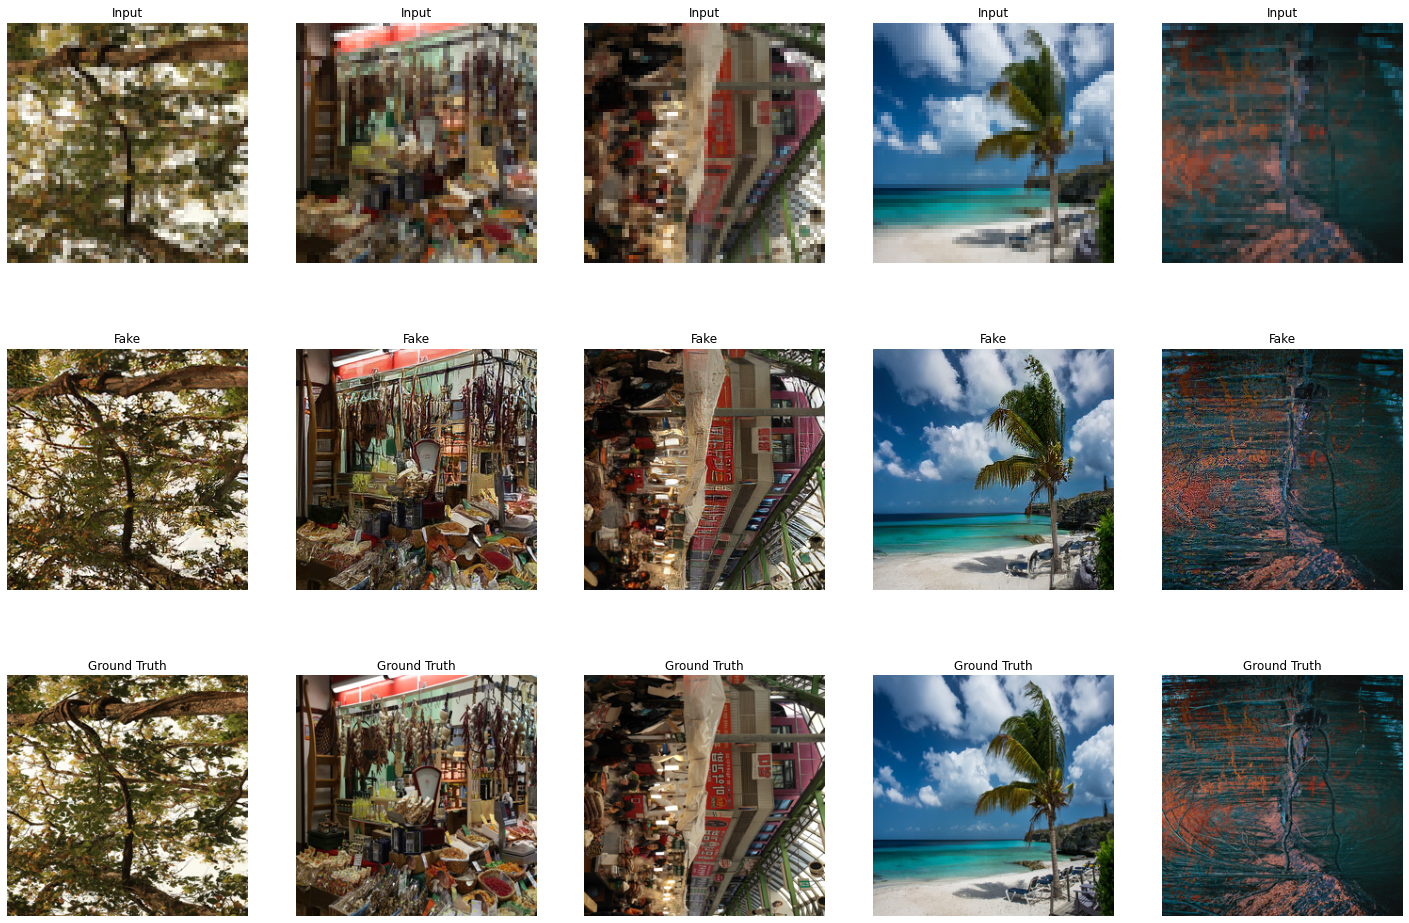

Generator Loss is 1.6511554718017578


In [45]:
test_dataset = DatasetFromFolder("/kaggle/input/cropflt/test", 256, 64)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=5,
                                            pin_memory=True,
                                            shuffle=True)

len(test_dataset)

lr, hr = next(iter(test_dataloader))

sr = netG(lr.to(device))
drawSamples(lr, sr.detach().cpu(), hr, (25, 17))
print(f"Generator Loss is {calc_gen_loss(lr.to(device), hr.to(device), 5).cpu().item()}")

Мы видим, что модель весьма хорошо справляется с данными картинками. Более того, некоторые SR картинки выглядят как будто детальнее и имеют более интересные текстуры, чем Ground Truth. А теперь попробуем другой фильтр, например, билинейный.

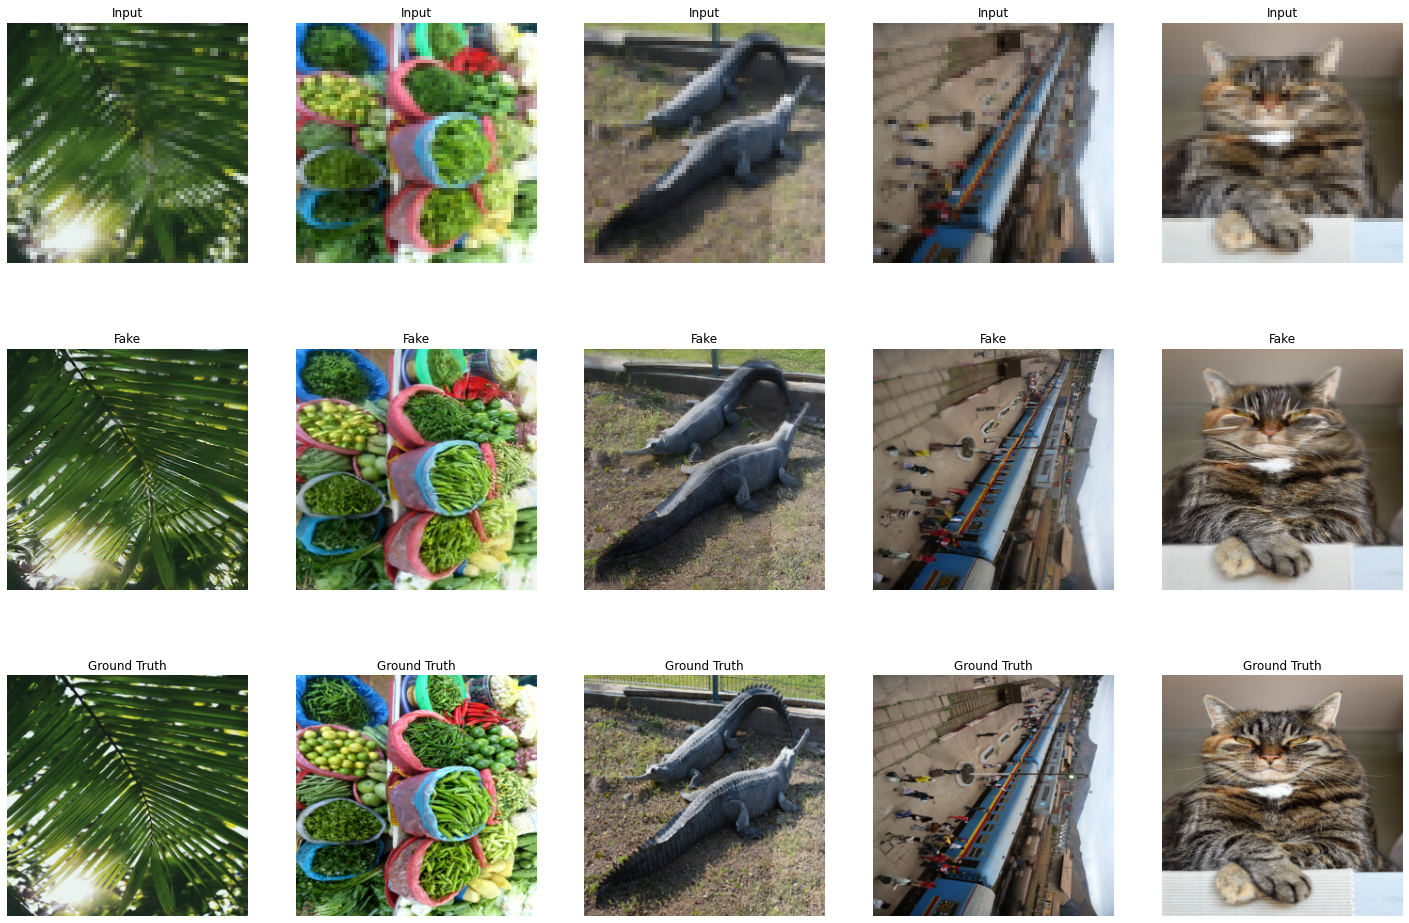

Generator Loss is 1.803834319114685


In [49]:
test_dataset = DatasetFromFolder("/kaggle/input/cropflt/test", 256, 64, Image.BILINEAR)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=5,
                                            pin_memory=True,
                                            shuffle=True)

lr, hr = next(iter(test_dataloader))

sr = netG(lr.to(device))

drawSamples(lr, sr.detach().cpu(), hr, (25, 17))
print(f"Generator Loss is {calc_gen_loss(lr.to(device), hr.to(device), 5).cpu().item()}")

С интерполировнием LR картинок, отличным от бикубического, результат уже вовсе не так хорош, как хотелось бы... Значит, модель переобучена под фильтр, что и следовало ожидать. Лосс генератора может сильно колебаться в зависимости от батча, но и он в среднем выше, если использовать билинейный фильтр.

# Заключение и возможные дальнейшие улучшения модели

Без учета (неисправимо) ошибочных попыток, на обучение данной модели было затрачено около 250-300 часов. Обучение производилось с использованием видеокарты Tesla V100 с 16 Gb видеопамяти, батчами по 16 изображений.

На качество обученной модели существенным образом влияет как качество выбранного датасета, так и его фильтрация от некачественных, нечетких картинок. Датасет должен содержать четкие детали и текстуры предметов. Кроме того, картинки могут акцентировать как высокоуровневые, так и низкоуровневые паттерны. Регион 128 пикселей является возможно не достаточно большим, и авторы [2] упоминают, что обучение на больших фрагментах позволяет нейросети запомнить больше семантической информации. Однако, это требует много VRAM. В качестве компромиса может быть использовано обучение на специальным образом аугментированном датасете, составленном из оргинальных HR картинок, 1/2HR изображений, 1/4HR изображений и тд. Из этих картинок уже вырезаются регионы по 128 пикселей, как обычно. Это позволяет нейросети изучить паттерны разного уровня, увеличивая объем датасета в несколько раз.

Кроме того, большое значение имеет способ получения LR изображений. В данной  работе был использован бикубический фильтр, как в [2]. Однако, имеет место переобучение модели под ядро фильтра. И модель работает лучше для синтетических LR-изображений, уменьшенных бикубическим фильтром, чем для любых других LR изображений. 

Чтобы избежать этого, можно использовать один из blind-sr методов. Например, уменьшать изображения с помощью kernelGAN: https://github.com/sefibk/KernelGAN


Эта модель создана для уменьшения фото с так называемыми "неизвестным ядром", которое в отличие от идеального ядра, как бикубический фильтр, обучено сохранять распределение патчей с исходного изображения. Нейросеть уменьшает каждое изображение с корректным специфичным для него ядром.

Ввиду слишком большой ресурсоемкости вдобавок к обучению ESRGAN, не решился применять Blind-SR в данной работе.


# Источники

[1] SRGAN   https://arxiv.org/abs/1609.04802

[2] ESRGAN  https://arxiv.org/abs/1809.00219